In [282]:
import gzip
import json
import glob
import random
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from reddit.models import BatchTransformerForContextMLM
from transformers import TFDistilBertForMaskedLM, DistilBertTokenizer
from reddit.utils import load_tfrecord, mask_and_stack_mlm

In [283]:
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

In [287]:
pattern_1 = '../logs/mlm/10context_3layers/*/metrics/*/mlm/*/log.json'
pattern_2 = '../logs/mlm/10context_2608/*/metrics/*/mlm/*/log.json'
pattern_3 = '../logs/mlm/10context_6layers_skipconn/*/metrics/*/mlm/*/log.json'
fs = glob.glob(pattern_1) + glob.glob(pattern_2) + glob.glob(pattern_3) 

<ipython-input-289-2f6aef900fd5>:30: RuntimeWarning: Mean of empty slice
  avg_loss = np.nanmean(d['test_losses'])
<ipython-input-289-2f6aef900fd5>:31: RuntimeWarning: Mean of empty slice
  avg_entropy = np.nanmean(d['test_entropy'])
<ipython-input-289-2f6aef900fd5>:32: RuntimeWarning: Mean of empty slice
  avg_true = np.nanmean(d['test_is_true_top'])
/home/roberta/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roberta/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/roberta/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/roberta/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empt

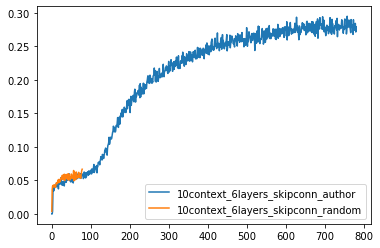

In [289]:
#fig, ax = plt.subplots(ncols=5, figsize=(20,3))


for idx, f in enumerate(fs):
    
    info = f.split('/')
    epoch = info[-2].split('-')[-1]
    if epoch == '0':
                #if epoch == 0:
        batch = info[3]
        grouping = info[4]
        model_info = info[-4].split('-')
        trained = model_info[2]
        frozen = model_info[1]
        if grouping != 'single':
            n_added = model_info[-6]
            context_agg = model_info[-4]
            aggregation = model_info[-3]
            reset = model_info[-2]
            fhead = model_info[-1]
        else:
            n_added = 0
            context_agg = 'none'
            aggregation = 'none'

        # Get test metrics
        d = json.load(open(f))


        avg_loss = np.nanmean(d['test_losses'])
        avg_entropy = np.nanmean(d['test_entropy'])
        avg_true = np.nanmean(d['test_is_true_top'])

        # Get ds of test metrics
        sd_loss = np.nanstd(d['test_losses'])
        sd_entropy = np.nanstd(d['test_entropy'])
        sd_true = np.nanstd(d['is_true_top'])

        # Get other metrics with rolling average
        if epoch != 'baseline':
            loss = np.nanmean(d['losses'])
            entropy  = np.nanmean(d['entropy'])
            true = np.nanmean(d['is_true_top'])
        else:
            loss, entropy, true = tuple([None]*3)

        dict_log = {'grouping': [grouping],
                     'trained': [trained],
                     'n_added': [n_added],
                     'frozen': [frozen],
                     'context_agg': [context_agg],
                     'aggregation': [aggregation],
                     'test_loss': [avg_loss],
                     'test_entropy': [avg_entropy],
                     'test_true': [avg_true],
                     'test_sd_loss': [sd_loss],
                     'test_sd_entropy': [sd_entropy],
                     'test_sd_true': [sd_true],
                     'loss': [loss],
                     'entropy': [entropy],
                     'true': [true],
                     'epoch': [epoch],
                     'model_id': '_'.join([grouping, 
                                           trained, 
                                           str(n_added), 
                                           frozen,
                                           context_agg,
                                           aggregation, fhead])}

        # Make into df
        df = pd.DataFrame(dict_log)
        if idx == 0:
            adf = df 
        else:
            adf = pd.concat([adf, df], ignore_index=True, sort=True)

        sns.lineplot(x=range(len(np.arange(0, 1000000, 1000))), 
                     y=[np.mean(d['is_true_top'][i:i+1000]) for i in np.arange(0, 1000000, 1000)],
                     label='_'.join([batch, grouping]),#'_'.join([grouping, 
                       #                trained, 
                       #                str(n_added), 
                       #                frozen,
                       #                context_agg,
                       #                aggregation,
                       #                reset, fhead]), 
                     #ax=ax[int(epoch)], 
                     legend=True)
for a in ax:
    a.set_ylim(0,.5)
plt.show()

In [239]:
adf['fine_tune'] = adf['frozen'].map({'0_1_2_3_4': 'last_layer', 'none': 'all'})

In [240]:
adf.sort_values(by='epoch')

,aggregation,context_agg,entropy,epoch,frozen,grouping,loss,model_id,n_added,test_entropy,test_loss,test_sd_entropy,test_sd_loss,test_sd_true,test_true,trained,true,fine_tune
1,concatenate,cls,4.861188,0,none,author,4.657852,author_pretrained_0_none_cls_concatenate_nohfr...,0,3.923773,3.689369,1.208667,1.525907,0.219044,0.386888,pretrained,0.284043,all
6,none,none,4.822755,0,none,single,4.621348,single_pretrained_0_none_none_none_nohfreeze,0,3.839111,3.668033,1.181854,1.525859,0.219077,0.389547,pretrained,0.287440,all
11,concatenate,cls,5.064014,0,none,author,4.863465,author_pretrained_0_none_cls_concatenate_nohfr...,0,4.253886,3.931571,1.219915,1.525396,0.212238,0.354914,pretrained,0.258741,all
15,none,none,4.990062,0,none,single,4.794620,single_pretrained_0_none_none_none_nohfreeze,0,NaN,NaN,NaN,NaN,0.214405,NaN,pretrained,0.267552,all
4,concatenate,cls,3.603307,1,none,author,3.458576,author_pretrained_0_none_cls_concatenate_nohfr...,0,3.431809,3.294079,1.191731,1.517552,0.215563,0.436223,pretrained,0.415563,all
9,none,none,3.575036,1,none,single,3.436929,single_pretrained_0_none_none_none_nohfreeze,0,3.473948,3.278178,1.183129,1.501692,0.215364,0.436478,pretrained,0.417511,all
14,concatenate,cls,3.832283,1,none,author,3.678200,author_pretrained_0_none_cls_concatenate_nohfr...,0,3.623157,3.488340,1.168284,1.519992,0.213924,0.408021,pretrained,0.385089,all
2,concatenate,cls,3.325810,2,none,author,3.182077,author_pretrained_0_none_cls_concatenate_nohfr...,0,3.260971,3.104895,1.177662,1.508301,0.217626,0.459787,pretrained,0.449895,all
7,none,none,3.307324,2,none,single,3.168573,single_pretrained_0_none_none_none_nohfreeze,0,3.287393,3.098904,1.185150,1.498498,0.217957,0.460034,pretrained,0.450543,all
12,concatenate,cls,3.520035,2,none,author,3.368278,author_pretrained_0_none_cls_concatenate_nohfr...,0,3.423834,3.292213,1.157066,1.508863,0.215958,0.432742,pretrained,0.422408,all
